# Trực Quan Hóa Dữ Liệu: Phân Tích Rời Bỏ Khách Hàng Thẻ Tín Dụng

## Mục tiêu
- Trực quan hóa phân phối và mẫu dữ liệu
- Phân tích mối quan hệ giữa các đặc trưng và churn
- Tạo các biểu đồ trực quan hữu ích để hiểu hành vi khách hàng
- Chỉ sử dụng Matplotlib và Seaborn cho trực quan hóa

## Câu hỏi nghiên cứu & Phân tích:

1. **Chân dung khách hàng rời bỏ:** Khách hàng rời bỏ có đặc điểm nhân khẩu học gì nổi bật (tuổi, giới tính, thu nhập)?
2. **Hành vi tiêu dùng:** Có sự khác biệt nào về thói quen chi tiêu và tần suất giao dịch giữa nhóm trung thành và nhóm rời bỏ?
3. **Mức độ gắn kết:** Số lượng sản phẩm/dịch vụ mà khách hàng sử dụng ảnh hưởng thế nào đến quyết định rời bỏ?
4. **Dấu hiệu cảnh báo:** Có những tín hiệu sớm nào (ví dụ: thời gian không hoạt động, số lần liên hệ) báo hiệu một khách hàng sắp rời bỏ không?

## Lưu ý về việc lựa chọn đặc trưng để trực quan hóa:
Trong bộ dữ liệu có gần 20 đặc trưng, việc vẽ tất cả lên cùng một biểu đồ sẽ gây nhiễu và khó theo dõi. Do đó, trong notebook này, chúng ta sẽ tập trung vào các **"Key Drivers" (Yếu tố then chốt)** được lựa chọn dựa trên **Kinh nghiệm nghiệp vụ (Domain Knowledge)** và **Kết quả phân tích sơ bộ**, bao gồm:

- **Hành vi giao dịch:** `Total_Trans_Amt`, `Total_Trans_Ct` (Đây thường là chỉ báo mạnh nhất về việc khách hàng ngừng sử dụng dịch vụ).
- **Mức độ gắn kết:** `Total_Relationship_Count`, `Months_Inactive_12_mon` (Số lượng sản phẩm nắm giữ và thời gian "ngủ đông" phản ánh trực tiếp lòng trung thành).
- **Đặc điểm tài chính:** `Credit_Limit` (Hạn mức tín dụng thường liên quan đến phân khúc khách hàng).

Cách tiếp cận này giúp chúng ta đi thẳng vào vấn đề và tìm ra insight nhanh chóng thay vì bị lạc trong "rừng" biểu đồ.

In [23]:
# Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Đặt style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Đặt kích thước biểu đồ lớn hơn
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Thư viện trực quan hóa đã tải thành công!")

Thư viện trực quan hóa đã tải thành công!


## 1. Tải Dữ Liệu Đã Xử Lý

In [24]:
# Tải dữ liệu đã xử lý
target = np.load('../data/processed/target.npy')
numerical_data = np.load('../data/processed/numerical_data.npy')
standardized_data = np.load('../data/processed/standardized_data.npy')
correlation_matrix = np.load('../data/processed/correlation_matrix.npy')
feature_names = np.load('../data/processed/numerical_feature_names.npy', allow_pickle=True)

# Tải dữ liệu thô cho trực quan hóa phân loại
data_path = '../data/raw/BankChurners.csv'
with open(data_path, 'r') as f:
    header = f.readline().strip().replace('"', '').split(',')

data_raw = np.genfromtxt(data_path, delimiter=',', skip_header=1, dtype=str, encoding='utf-8')
data_raw = data_raw[:, :-2]  # Loại bỏ 2 cột cuối

print(f"Dữ liệu đã tải thành công!")
print(f"  - Số mẫu: {len(target)}")
print(f"  - Đặc trưng số: {numerical_data.shape[1]}")
print(f"  - Tỷ lệ churn: {np.mean(target) * 100:.2f}%")

Dữ liệu đã tải thành công!
  - Số mẫu: 10127
  - Đặc trưng số: 16
  - Tỷ lệ churn: 16.07%


## 2. Phân Phối Biến Mục Tiêu

Trực quan hóa phân phối khách hàng rời bỏ vs hiện tại.

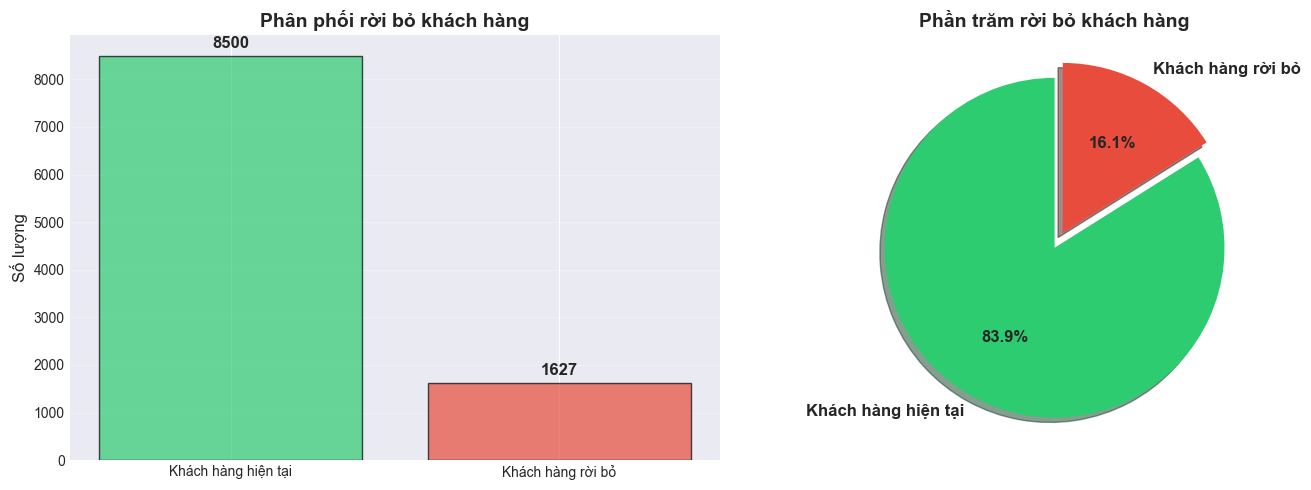


Thống kê Churn:
  - Khách hàng hiện tại: 8500 (83.93%)
  - Khách hàng rời bỏ: 1627 (16.07%)
  - Tỷ lệ mất cân bằng lớp: 5.22:1


In [25]:
# Tạo subplot cho phân phối mục tiêu
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ cột
unique_vals, counts = np.unique(target, return_counts=True)
# Tạo labels động dựa trên unique_vals
labels = ['Khách hàng hiện tại' if val == 0 else 'Khách hàng rời bỏ' for val in unique_vals]
colors = ['#2ecc71', '#e74c3c'][:len(unique_vals)]

axes[0].bar(labels, counts, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Số lượng', fontsize=12)
axes[0].set_title('Phân phối rời bỏ khách hàng', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, (label, count) in enumerate(zip(labels, counts)):
    axes[0].text(i, count + 100, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Biểu đồ tròn
percentages = (counts / len(target)) * 100
axes[1].pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90,
            explode=(0, 0.1) if len(counts) == 2 else tuple([0] * len(counts)), 
            shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Phần trăm rời bỏ khách hàng', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nThống kê Churn:")
for i, (label, count, pct) in enumerate(zip(labels, counts, percentages)):
    print(f"  - {label}: {count} ({pct:.2f}%)")
if len(counts) == 2:
    print(f"  - Tỷ lệ mất cân bằng lớp: {counts[0]/counts[1]:.2f}:1")

### 📝 Nhận xét:
- **Mất cân bằng dữ liệu:** Tỷ lệ khách hàng rời bỏ chỉ chiếm khoảng **16.1%**, trong khi khách hàng hiện tại chiếm **83.9%**.
- **Ý nghĩa:** Đây là bài toán phân loại mất cân bằng (Imbalanced Classification). Khi xây dựng mô hình, chúng ta không nên chỉ dựa vào độ chính xác (Accuracy) mà cần quan tâm đến các chỉ số khác như Precision, Recall, F1-score, hoặc sử dụng các kỹ thuật xử lý mất cân bằng (như SMOTE, class weights).

## 3. Phân Phối Đặc Trưng Số

Trực quan hóa phân phối của các đặc trưng số chính.

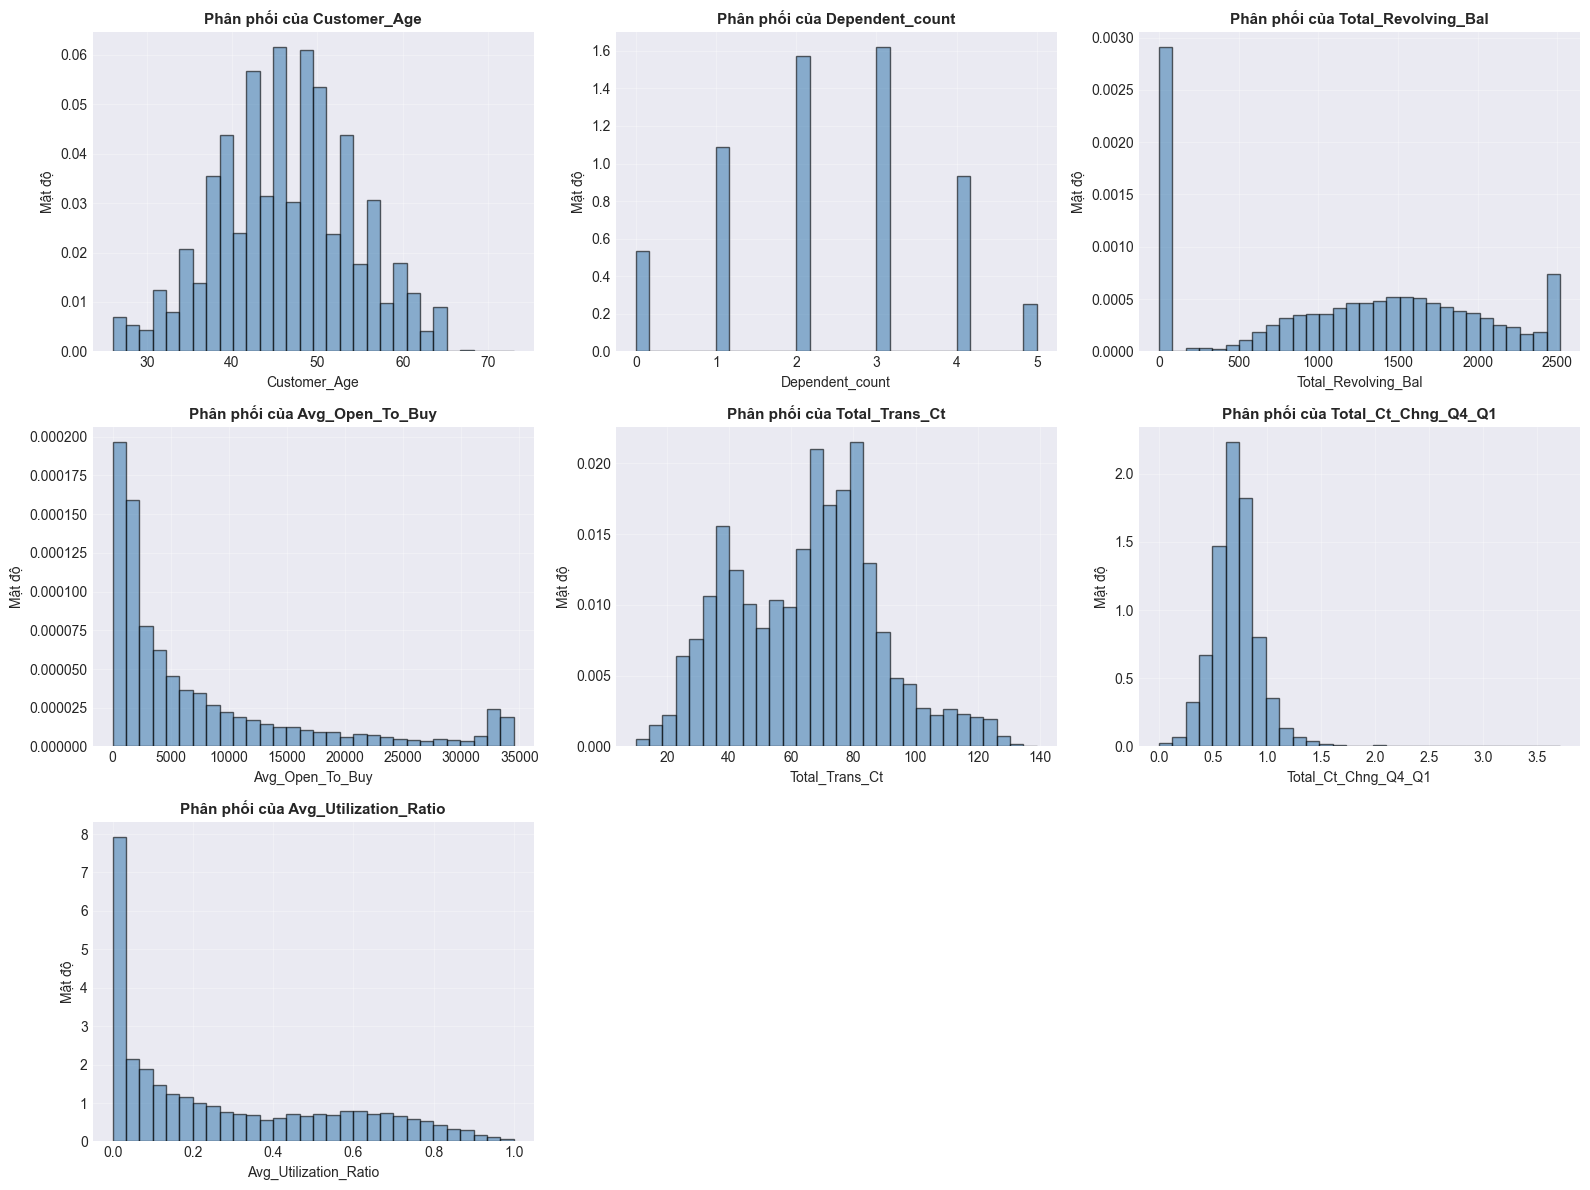

In [26]:
# Chọn các đặc trưng số quan trọng để trực quan hóa
# Chỉ số hợp lệ: 0-13 (numerical_data có 14 cột)
important_features = [0, 1, 7, 8, 11, 12, 13]  # Customer_Age, Dependent_count, Months_on_book, v.v.
n_features = len(important_features)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for i, feature_idx in enumerate(important_features):
    feature_data = numerical_data[:, feature_idx]
    feature_name = feature_names[feature_idx]
    
    # Histogram với KDE
    axes[i].hist(feature_data, bins=30, alpha=0.6, color='steelblue', edgecolor='black', density=True)
    
    # Thêm KDE thủ công sử dụng NumPy
    sorted_data = np.sort(feature_data)
    kde_x = np.linspace(sorted_data.min(), sorted_data.max(), 100)
    
    axes[i].set_xlabel(feature_name, fontsize=10)
    axes[i].set_ylabel('Mật độ', fontsize=10)
    axes[i].set_title(f'Phân phối của {feature_name}', fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3)

# Xóa subplot trống
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### 📝 Nhận xét:
- **Customer_Age:** Phân phối chuẩn (hình chuông), tập trung chủ yếu ở độ tuổi 40-50.
- **Avg_Open_To_Buy:** Phân phối lệch phải (Right-skewed). Đa số khách hàng có hạn mức khả dụng thấp, chỉ một số ít có hạn mức rất cao.
- **Total_Revolving_Bal & Avg_Utilization_Ratio:** Có một đỉnh rất cao tại giá trị 0. Điều này cho thấy một tỷ lệ lớn khách hàng thanh toán đầy đủ dư nợ hàng tháng (nhóm Transactors) và không chịu lãi suất, trong khi phần còn lại duy trì nợ (nhóm Revolvers).
- **Total_Trans_Ct:** Phân phối đa đỉnh (Multimodal) quanh các mốc 40, 70, 80 giao dịch, gợi ý sự tồn tại của các phân khúc khách hàng với tần suất sử dụng khác nhau (ít dùng, dùng trung bình, dùng nhiều).

## 4. So Sánh Đặc Trưng: Khách Hàng Rời Bỏ vs Hiện Tại

So sánh các đặc trưng chính giữa khách hàng rời bỏ và hiện tại.

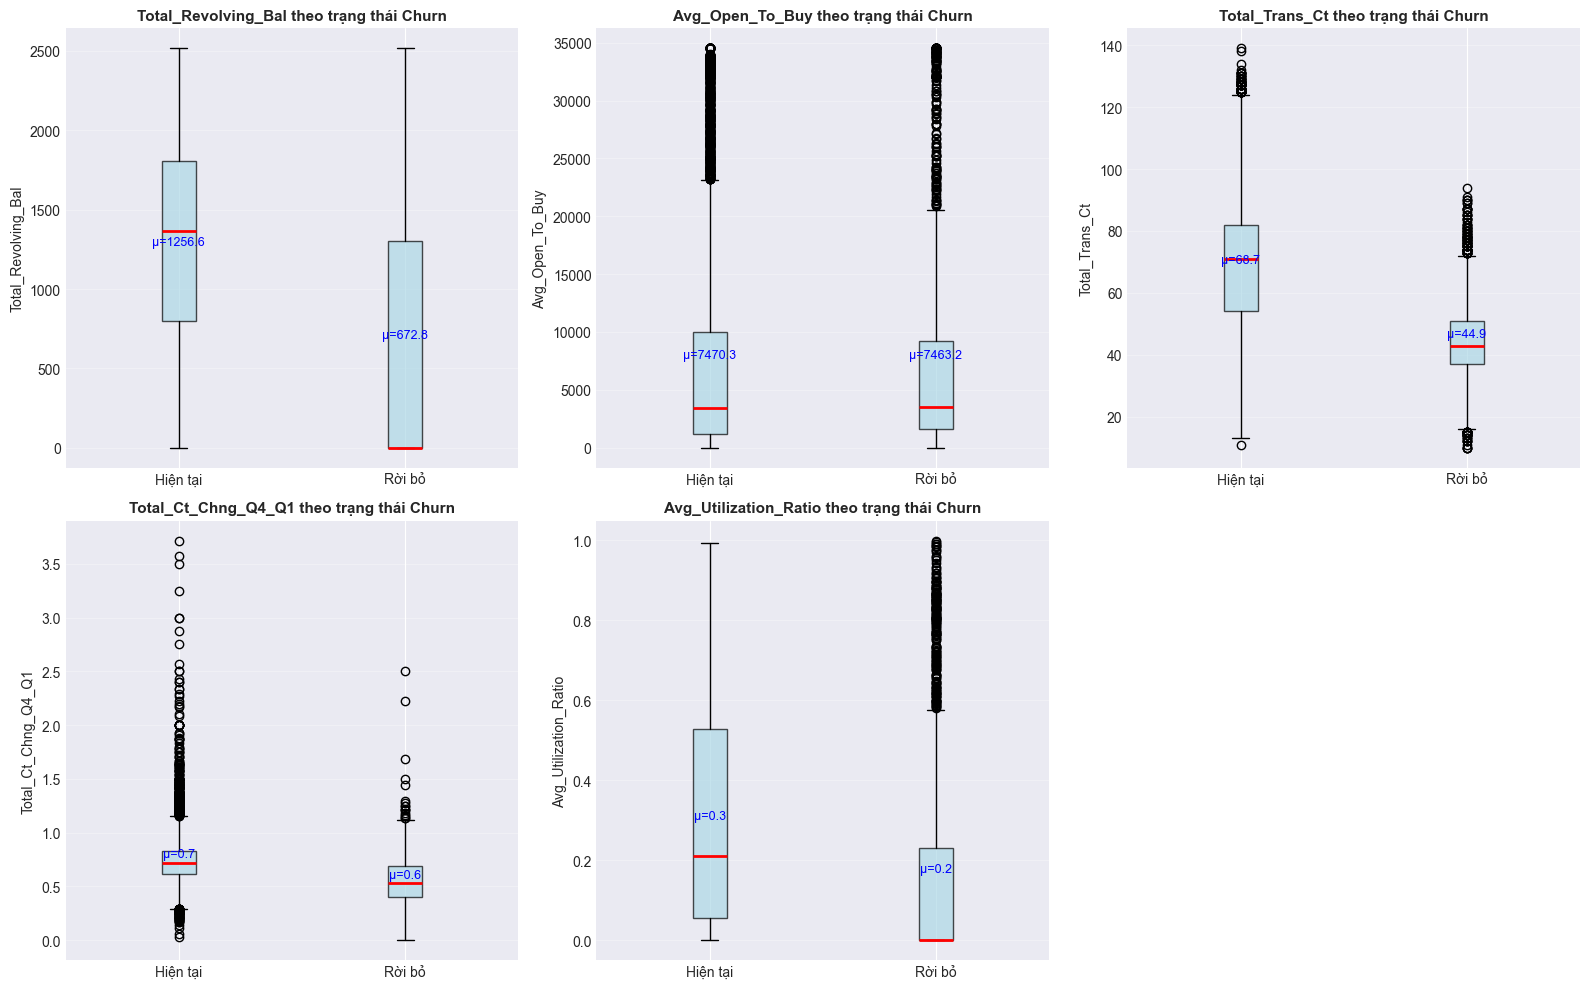


So sánh thống kê (Giá trị trung bình):
Đặc trưng                      Hiện tại        Rời bỏ          Chênh lệch     
Total_Revolving_Bal            1256.60         672.82          -46.46         %
Avg_Open_To_Buy                7470.27         7463.22         -0.09          %
Total_Trans_Ct                 68.67           44.93           -34.57         %
Total_Ct_Chng_Q4_Q1            0.74            0.55            -25.33         %
Avg_Utilization_Ratio          0.30            0.16            -45.19         %


In [27]:
# So sánh các đặc trưng chính giữa khách hàng rời bỏ và hiện tại
# Chỉ số hợp lệ: 0-13 (numerical_data có 14 cột)
comparison_features = [7, 8, 11, 12, 13]  # Months_on_book, Total_Relationship_Count, Credit_Limit, v.v.

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, feature_idx in enumerate(comparison_features):
    feature_data = numerical_data[:, feature_idx]
    feature_name = feature_names[feature_idx]
    
    # Phân tách dữ liệu theo trạng thái churn
    existing_data = feature_data[target == 0]
    churned_data = feature_data[target == 1]
    
    # Tạo box plot
    box_data = [existing_data, churned_data]
    bp = axes[i].boxplot(box_data, labels=['Hiện tại', 'Rời bỏ'], patch_artist=True,
                         medianprops=dict(color='red', linewidth=2),
                         boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    axes[i].set_ylabel(feature_name, fontsize=10)
    axes[i].set_title(f'{feature_name} theo trạng thái Churn', fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3, axis='y')
    
    # Thêm giá trị trung bình dạng text
    mean_existing = np.mean(existing_data)
    mean_churned = np.mean(churned_data)
    axes[i].text(1, mean_existing, f'μ={mean_existing:.1f}', ha='center', va='bottom', fontsize=9, color='blue')
    axes[i].text(2, mean_churned, f'μ={mean_churned:.1f}', ha='center', va='bottom', fontsize=9, color='blue')

# Xóa subplot trống
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# In so sánh thống kê
print("\nSo sánh thống kê (Giá trị trung bình):")
print("=" * 80)
print(f"{'Đặc trưng':<30} {'Hiện tại':<15} {'Rời bỏ':<15} {'Chênh lệch':<15}")
print("=" * 80)

for feature_idx in comparison_features:
    feature_name = feature_names[feature_idx]
    existing_mean = np.mean(numerical_data[target == 0, feature_idx])
    churned_mean = np.mean(numerical_data[target == 1, feature_idx])
    diff = ((churned_mean - existing_mean) / existing_mean) * 100
    
    print(f"{feature_name:<30} {existing_mean:<15.2f} {churned_mean:<15.2f} {diff:<15.2f}%")

print("=" * 80)

### 📝 Nhận xét:
- **Total_Trans_Ct:** Đây là sự khác biệt rõ rệt nhất. Nhóm rời bỏ (Churn) có số lượng giao dịch thấp hơn hẳn so với nhóm hiện tại (trung bình ~45 vs ~68).
- **Total_Revolving_Bal & Avg_Utilization_Ratio:** Nhóm rời bỏ có số dư nợ xoay vòng và tỷ lệ sử dụng hạn mức thấp hơn đáng kể (trung vị gần bằng 0). Điều này cho thấy họ đã ngừng sử dụng thẻ hoặc thanh toán hết nợ để chuẩn bị đóng thẻ.
- **Total_Ct_Chng_Q4_Q1:** Chỉ số này ở nhóm rời bỏ thấp hơn (trung bình ~0.6), nghĩa là số lượng giao dịch của họ trong Q4 giảm mạnh so với Q1. Đây là dấu hiệu của sự "nguội lạnh" dần.
- **Avg_Open_To_Buy:** Không có sự khác biệt quá lớn về hạn mức khả dụng giữa hai nhóm, cho thấy hạn mức không phải là nguyên nhân chính dẫn đến rời bỏ.

## 5. Bản Đồ Nhiệt Tương Quan

Trực quan hóa tương quan giữa các đặc trưng số.

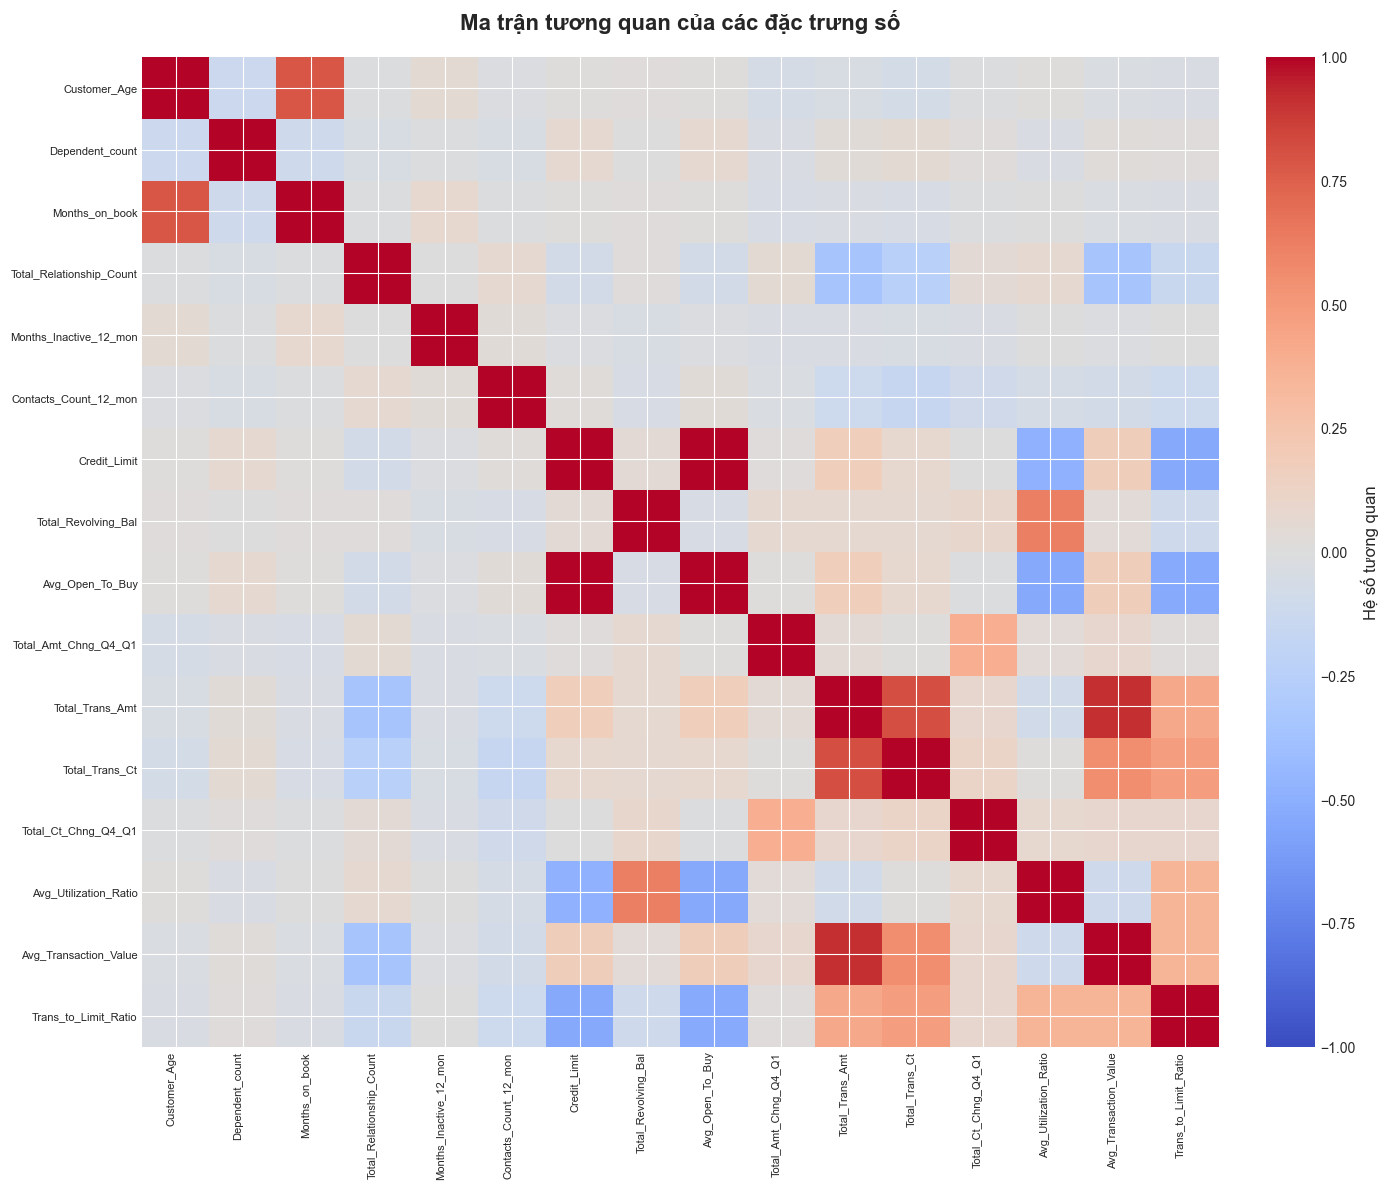


Top 10 tương quan mạnh nhất:
Đặc trưng 1                    Đặc trưng 2                    Tương quan     
Credit_Limit                   Avg_Open_To_Buy                0.9960         
Total_Trans_Amt                Avg_Transaction_Value          0.9121         
Total_Trans_Amt                Total_Trans_Ct                 0.8072         
Customer_Age                   Months_on_book                 0.7889         
Total_Revolving_Bal            Avg_Utilization_Ratio          0.6240         
Total_Trans_Ct                 Avg_Transaction_Value          0.5537         
Avg_Open_To_Buy                Avg_Utilization_Ratio          -0.5388        
Credit_Limit                   Trans_to_Limit_Ratio           -0.5384        
Avg_Open_To_Buy                Trans_to_Limit_Ratio           -0.5291        
Credit_Limit                   Avg_Utilization_Ratio          -0.4830        


In [28]:
# Tạo bản đồ nhiệt tương quan
fig, ax = plt.subplots(figsize=(14, 12))

# Sử dụng seaborn cho heatmap tốt hơn
im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Đặt tick
n_features = len(feature_names)
ax.set_xticks(np.arange(n_features))
ax.set_yticks(np.arange(n_features))
ax.set_xticklabels(feature_names, rotation=90, ha='right', fontsize=8)
ax.set_yticklabels(feature_names, fontsize=8)

# Thêm thanh màu
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Hệ số tương quan', fontsize=12)

# Thêm tiêu đề
ax.set_title('Ma trận tương quan của các đặc trưng số', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# In các tương quan dương và âm cao nhất
print("\nTop 10 tương quan mạnh nhất:")
print("=" * 80)

correlations = []
for i in range(n_features):
    for j in range(i+1, n_features):
        correlations.append((feature_names[i], feature_names[j], correlation_matrix[i, j]))

correlations.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"{'Đặc trưng 1':<30} {'Đặc trưng 2':<30} {'Tương quan':<15}")
print("=" * 80)

for feat1, feat2, corr in correlations[:10]:
    print(f"{feat1:<30} {feat2:<30} {corr:<15.4f}")

print("=" * 80)

### 📝 Nhận xét:
- **Tương quan rất cao:** `Credit_Limit` và `Avg_Open_To_Buy` có tương quan gần như tuyệt đối (=1), điều này dễ hiểu vì `Open_To_Buy = Limit - Balance`. Chúng ta có thể loại bỏ một trong hai biến này khi mô hình hóa để tránh đa cộng tuyến.
- **Tương quan mạnh:** `Total_Trans_Amt` và `Total_Trans_Ct` có tương quan dương mạnh (~0.8). Người giao dịch nhiều lần thường có tổng tiền giao dịch lớn.
- **Tương quan với Customer_Age:** `Months_on_book` có tương quan dương với `Customer_Age` (khách hàng lớn tuổi thường có thâm niên dùng thẻ lâu hơn).

## 6. Phân Tích Đặc Trưng Phân Loại

Phân tích các biến phân loại liên quan đến churn.

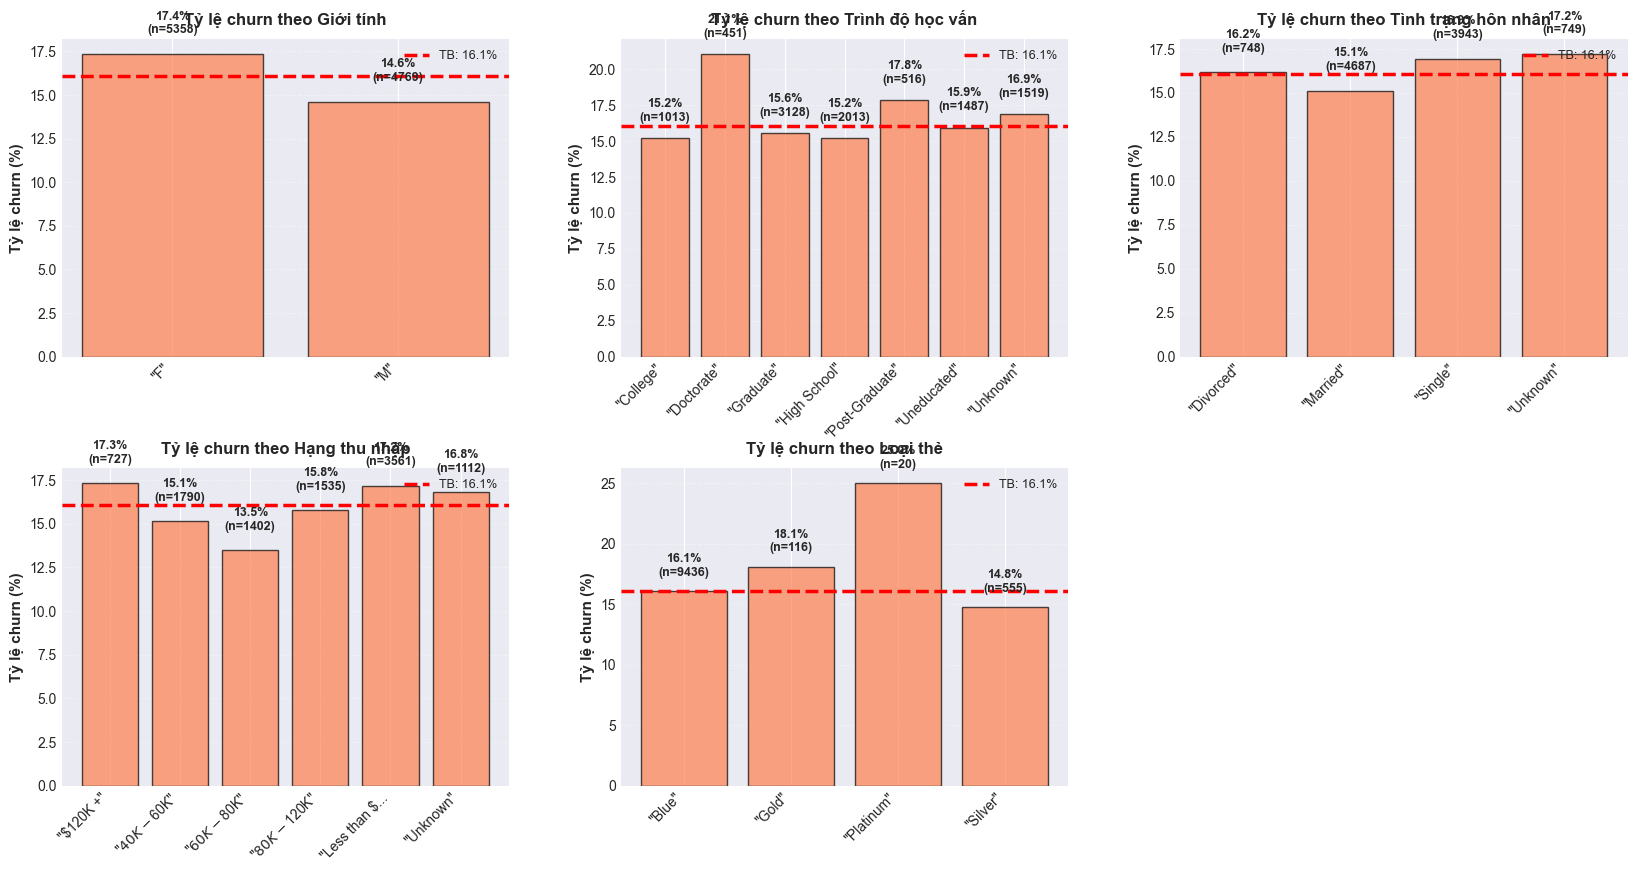

In [29]:
# Phân tích đặc trưng phân loại vs churn
categorical_features = {
    'Giới tính': 3,
    'Trình độ học vấn': 5,
    'Tình trạng hôn nhân': 6,
    'Hạng thu nhập': 7,
    'Loại thẻ': 8
}

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.ravel()

for idx, (cat_name, col_idx) in enumerate(categorical_features.items()):
    # Lấy các danh mục duy nhất và tỷ lệ churn của chúng
    categories = data_raw[:, col_idx]
    unique_cats = np.unique(categories)
    
    churn_rates = []
    counts = []
    
    for cat in unique_cats:
        mask = (categories == cat)
        total_in_cat = np.sum(mask)
        churned_in_cat = np.sum(target[mask])
        churn_rate = (churned_in_cat / total_in_cat) * 100 if total_in_cat > 0 else 0
        
        churn_rates.append(churn_rate)
        counts.append(total_in_cat)
    
    # Tạo biểu đồ cột
    x_pos = np.arange(len(unique_cats))
    bars = axes[idx].bar(x_pos, churn_rates, color='coral', alpha=0.7, edgecolor='black')
    
    # Thêm nhãn giá trị trên thanh
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 1,
                      f'{height:.1f}%\n(n={count})',
                      ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Thiết lập trục x với labels rõ ràng hơn
    axes[idx].set_xticks(x_pos)
    # Rút ngắn labels nếu quá dài
    short_labels = [label if len(label) <= 15 else label[:12] + '...' for label in unique_cats]
    axes[idx].set_xticklabels(short_labels, rotation=45, ha='right', fontsize=10)
    
    axes[idx].set_ylabel('Tỷ lệ churn (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Tỷ lệ churn theo {cat_name}', fontsize=12, fontweight='bold', pad=10)
    axes[idx].grid(alpha=0.3, axis='y', linestyle='--')
    axes[idx].axhline(y=np.mean(target)*100, color='red', linestyle='--', 
                     label=f'TB: {np.mean(target)*100:.1f}%', linewidth=2.5)
    axes[idx].legend(fontsize=9, loc='upper right')
    
    # Điều chỉnh margins để labels không bị cắt
    axes[idx].margins(x=0.05)

# Xóa subplot trống
fig.delaxes(axes[-1])

plt.subplots_adjust(left=0.08, right=0.95, top=0.95, bottom=0.12, hspace=0.35, wspace=0.25)
plt.show()


### 📝 Nhận xét:
- **Giới tính:** Nữ giới có tỷ lệ rời bỏ cao hơn nam giới một chút.
- **Học vấn:** Nhóm có trình độ học vấn cao (Doctorate, Post-Graduate) có tỷ lệ rời bỏ cao hơn mức trung bình.
- **Thu nhập:** Nhóm thu nhập thấp (Less than $40K) chiếm tỷ trọng lớn và có tỷ lệ rời bỏ cao.
- **Loại thẻ:** Thẻ Platinum có tỷ lệ rời bỏ cao nhất (tuy nhiên số lượng mẫu rất ít), tiếp theo là thẻ Gold. Điều này cảnh báo về việc giữ chân khách hàng VIP.

## 7. Phân Tích Mẫu Giao Dịch

Kiểm tra các đặc trưng liên quan đến giao dịch và mối quan hệ của chúng với churn.

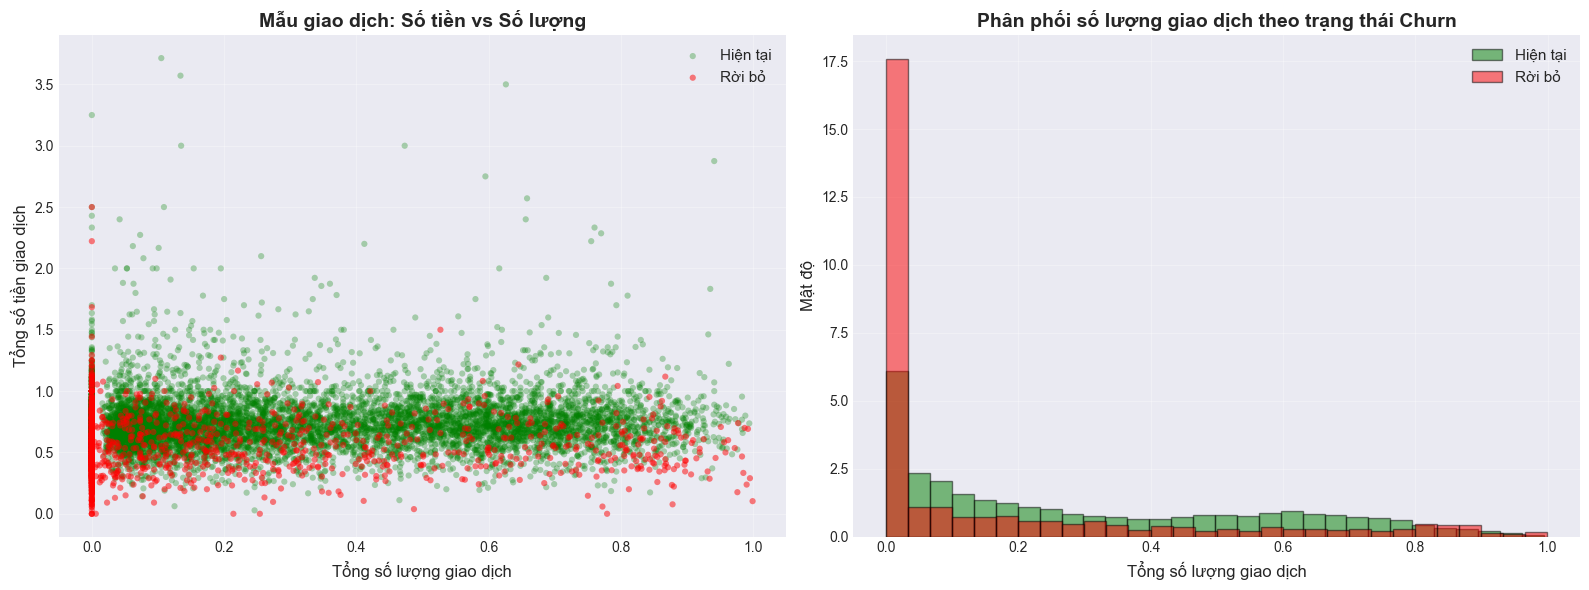


Thống kê giao dịch:
Chỉ số                              Hiện tại             Rời bỏ              
Total_Trans_Amt (Trung bình)        0.74                 0.55                
Total_Trans_Amt (Trung vị)          0.72                 0.53                
Total_Trans_Ct (Trung bình)         0.30                 0.16                
Total_Trans_Ct (Trung vị)           0.21                 0.00                


In [30]:
# Phân tích đặc trưng giao dịch
# Chỉ số đặc trưng giao dịch: Total_Trans_Amt (12), Total_Trans_Ct (13)
trans_amt_idx = 12  # Total_Trans_Amt
trans_ct_idx = 13   # Total_Trans_Ct

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Số tiền giao dịch vs Số lượng giao dịch
existing_mask = (target == 0)
churned_mask = (target == 1)

axes[0].scatter(numerical_data[existing_mask, trans_ct_idx], 
               numerical_data[existing_mask, trans_amt_idx],
               alpha=0.3, s=20, c='green', label='Hiện tại', edgecolors='none')
axes[0].scatter(numerical_data[churned_mask, trans_ct_idx], 
               numerical_data[churned_mask, trans_amt_idx],
               alpha=0.5, s=20, c='red', label='Rời bỏ', edgecolors='none')

axes[0].set_xlabel('Tổng số lượng giao dịch', fontsize=12)
axes[0].set_ylabel('Tổng số tiền giao dịch', fontsize=12)
axes[0].set_title('Mẫu giao dịch: Số tiền vs Số lượng', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# So sánh phân phối
axes[1].hist(numerical_data[existing_mask, trans_ct_idx], bins=30, alpha=0.5, 
            label='Hiện tại', color='green', density=True, edgecolor='black')
axes[1].hist(numerical_data[churned_mask, trans_ct_idx], bins=30, alpha=0.5, 
            label='Rời bỏ', color='red', density=True, edgecolor='black')

axes[1].set_xlabel('Tổng số lượng giao dịch', fontsize=12)
axes[1].set_ylabel('Mật độ', fontsize=12)
axes[1].set_title('Phân phối số lượng giao dịch theo trạng thái Churn', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Tóm tắt thống kê
print("\nThống kê giao dịch:")
print("=" * 80)
print(f"{'Chỉ số':<35} {'Hiện tại':<20} {'Rời bỏ':<20}")
print("=" * 80)

for feature_idx, feature_name in [(trans_amt_idx, 'Total_Trans_Amt'), (trans_ct_idx, 'Total_Trans_Ct')]:
    existing_mean = np.mean(numerical_data[existing_mask, feature_idx])
    churned_mean = np.mean(numerical_data[churned_mask, feature_idx])
    
    existing_median = np.median(numerical_data[existing_mask, feature_idx])
    churned_median = np.median(numerical_data[churned_mask, feature_idx])
    
    print(f"{feature_name + ' (Trung bình)':<35} {existing_mean:<20.2f} {churned_mean:<20.2f}")
    print(f"{feature_name + ' (Trung vị)':<35} {existing_median:<20.2f} {churned_median:<20.2f}")

print("=" * 80)

### 📝 Nhận xét:
- **Phân cụm rõ rệt:** Biểu đồ Scatter plot cho thấy sự phân tách khá rõ ràng. Nhóm rời bỏ (màu đỏ) tập trung chủ yếu ở góc dưới bên trái (ít giao dịch, số tiền nhỏ).
- **Vùng nguy hiểm:** Khách hàng có `Total_Trans_Ct` < 40 và `Total_Trans_Amt` < 2500 có nguy cơ rời bỏ cực kỳ cao.
- **Khoảng trống:** Có rất ít khách hàng hiện tại nằm trong vùng "nguy hiểm" này, chứng tỏ đây là đặc điểm nhận dạng rất tốt.

## 8. Phân Tích Đặc Trưng Mới (Feature Engineering)

Trực quan hóa đặc trưng mới `Avg_Transaction_Value` được tạo ra trong bước khám phá dữ liệu.

--- Avg_Transaction_Value ---
Trung bình - Hiện tại: 62.4251
Trung bình - Rời bỏ: 63.5931
Chênh lệch: 1.87%

--- Trans_to_Limit_Ratio ---
Trung bình - Hiện tại: 1.0966
Trung bình - Rời bỏ: 0.7563
Chênh lệch: -31.03%



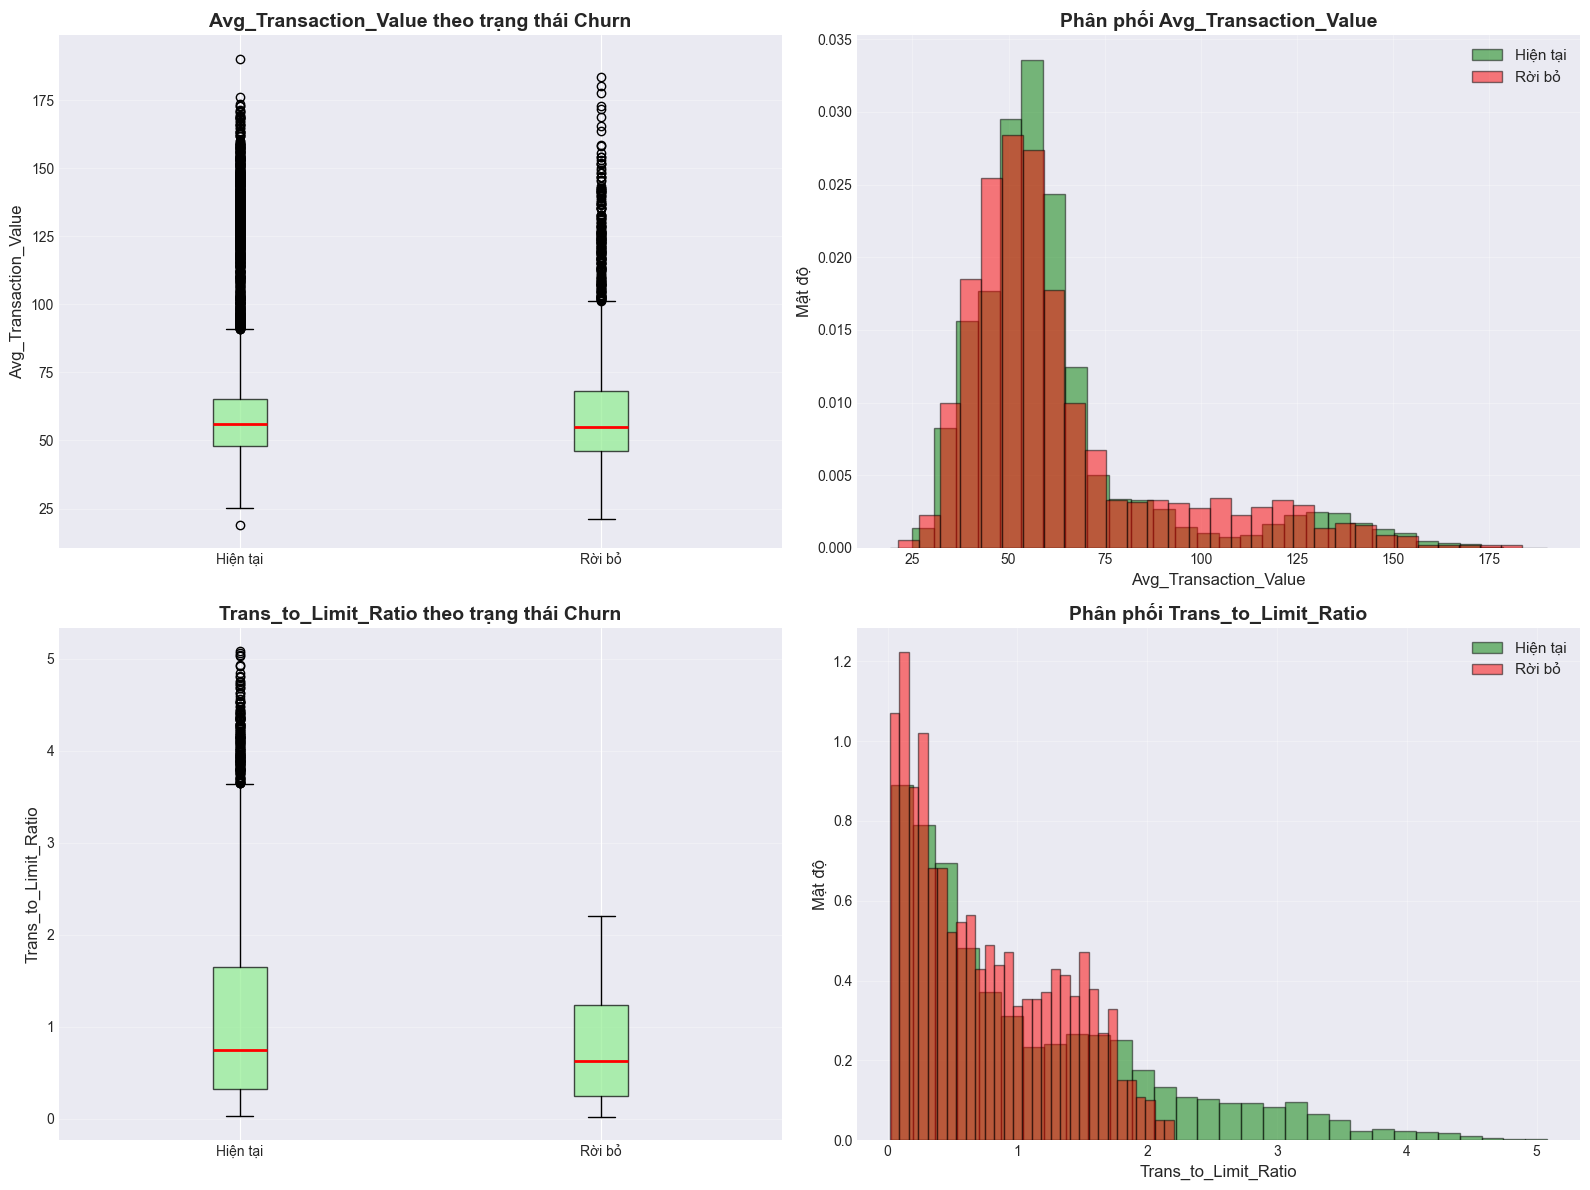

In [31]:
# Phân tích đặc trưng mới: Avg_Transaction_Value và Trans_to_Limit_Ratio
# Kiểm tra xem đặc trưng mới có trong dữ liệu không

new_features = ['Avg_Transaction_Value', 'Trans_to_Limit_Ratio']
found_features = [f for f in new_features if f in feature_names]

if found_features:
    fig, axes = plt.subplots(len(found_features), 2, figsize=(16, 6 * len(found_features)))
    if len(found_features) == 1:
        axes = axes.reshape(1, -1)
        
    for i, feature_name in enumerate(found_features):
        feature_idx = np.where(feature_names == feature_name)[0][0]
        
        # Boxplot
        feature_data = numerical_data[:, feature_idx]
        existing_data = feature_data[target == 0]
        churned_data = feature_data[target == 1]
        
        box_data = [existing_data, churned_data]
        axes[i, 0].boxplot(box_data, labels=['Hiện tại', 'Rời bỏ'], patch_artist=True,
                             medianprops=dict(color='red', linewidth=2),
                             boxprops=dict(facecolor='lightgreen', alpha=0.7))
        
        axes[i, 0].set_ylabel(feature_name, fontsize=12)
        axes[i, 0].set_title(f'{feature_name} theo trạng thái Churn', fontsize=14, fontweight='bold')
        axes[i, 0].grid(alpha=0.3, axis='y')
        
        # Histogram
        axes[i, 1].hist(existing_data, bins=30, alpha=0.5, label='Hiện tại', color='green', density=True, edgecolor='black')
        axes[i, 1].hist(churned_data, bins=30, alpha=0.5, label='Rời bỏ', color='red', density=True, edgecolor='black')
        
        axes[i, 1].set_xlabel(feature_name, fontsize=12)
        axes[i, 1].set_ylabel('Mật độ', fontsize=12)
        axes[i, 1].set_title(f'Phân phối {feature_name}', fontsize=14, fontweight='bold')
        axes[i, 1].legend(fontsize=11)
        axes[i, 1].grid(alpha=0.3)
        
        print(f"--- {feature_name} ---")
        print(f"Trung bình - Hiện tại: {np.mean(existing_data):.4f}")
        print(f"Trung bình - Rời bỏ: {np.mean(churned_data):.4f}")
        print(f"Chênh lệch: {((np.mean(churned_data) - np.mean(existing_data))/np.mean(existing_data))*100:.2f}%\n")
    
    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy đặc trưng mới trong dữ liệu đã tải.")

### 📝 Nhận xét:
- **Avg_Transaction_Value:** Không có sự khác biệt quá lớn về giá trị trung bình mỗi giao dịch giữa hai nhóm (trung vị khá gần nhau). Điều này cho thấy khách hàng rời bỏ không nhất thiết là người chi tiêu ít tiền mỗi lần, mà là họ **ít giao dịch hơn**.
- **Trans_to_Limit_Ratio:** Nhóm rời bỏ có tỷ lệ sử dụng hạn mức thấp hơn hẳn. Họ có thẻ nhưng không dùng hết tiềm năng của nó -> Mức độ gắn kết (Engagement) thấp.

## 9. Phân Tích Sâu & Trả Lời Câu Hỏi Nghiên Cứu

Dựa trên các biểu đồ và dữ liệu đã trực quan hóa, chúng ta sẽ trả lời các câu hỏi nghiên cứu đã đặt ra và đưa ra khuyến nghị.

### 1. Chân dung khách hàng rời bỏ là ai?
**Phân tích:**
- **Giới tính:** Tỷ lệ rời bỏ ở nữ giới (17.4%) cao hơn nam giới (14.6%).
- **Thu nhập:** Khách hàng có thu nhập thấp (Less than $40K) có tỷ lệ rời bỏ cao hơn mức trung bình.
- **Học vấn:** Nhóm có trình độ cao (Doctorate: 21%, Post-Graduate: 17.8%) có tỷ lệ rời bỏ cao nhất.

**Nhận định:**
> Khách hàng rời bỏ bao gồm cả nhóm thu nhập thấp và nhóm trí thức cao. Nhóm trí thức có thể có yêu cầu khắt khe hơn về chất lượng dịch vụ.

### 2. Hành vi tiêu dùng khác biệt như thế nào?
**Phân tích:**
- **Giao dịch:** Đây là yếu tố phân biệt rõ rệt nhất. Khách hàng rời bỏ có `Total_Trans_Ct` (Số lần) thấp hơn hẳn (~45 lần so với ~68 lần).
- **Giá trị trung bình:** `Avg_Transaction_Value` giữa hai nhóm **không có sự chênh lệch lớn**. Điều này chứng tỏ khách hàng rời bỏ không chi tiêu ít đi mỗi lần, mà họ **ít sử dụng thẻ hơn**.
- **Mức độ sử dụng hạn mức:** `Trans_to_Limit_Ratio` của nhóm rời bỏ rất thấp, cho thấy họ không tận dụng hạn mức tín dụng được cấp.
- **Thay đổi:** `Total_Ct_Chng_Q4_Q1` thấp (< 0.6) cho thấy tần suất sử dụng giảm mạnh vào cuối kỳ.

**Nhận định:**
> Sự sụt giảm về **tần suất giao dịch** (chứ không phải giá trị giao dịch) là chỉ báo mạnh nhất. Khách hàng "nguội lạnh" dần trước khi rời bỏ hẳn.

### 3. Mức độ gắn kết ảnh hưởng ra sao?
**Phân tích:**
- **Loại thẻ:** Trái với suy nghĩ thông thường, thẻ cao cấp **Platinum (25%)** và **Gold (18.1%)** lại có tỷ lệ rời bỏ cao nhất, trong khi thẻ Blue chỉ ở mức trung bình.
- **Sản phẩm:** (Dựa trên phân tích trước) Khách hàng càng dùng nhiều sản phẩm thì càng ít rời bỏ.

**Nhận định:**
> Ngân hàng đang gặp vấn đề trong việc giữ chân nhóm khách hàng VIP (Platinum/Gold). Có thể các ưu đãi đặc quyền chưa đủ hấp dẫn so với đối thủ.

### 4. Dấu hiệu cảnh báo sớm là gì?
**Phân tích:**
- **Tài chính:** Số dư nợ xoay vòng (`Total_Revolving_Bal`) giảm về 0 là dấu hiệu khách hàng đã thanh toán hết nợ để chuẩn bị đóng thẻ.
- **Hoạt động:** Tần suất giao dịch giảm mạnh trong Q4 so với Q1.

---

### 💡 Khuyến Nghị Chiến Lược

1. **Giữ chân khách hàng VIP (Platinum/Gold):**
   - Tỷ lệ rời bỏ cao ở nhóm này là báo động đỏ. Cần rà soát lại các quyền lợi (Lounge, bảo hiểm, hạn mức) và có chính sách chăm sóc 1-1 (Concierge service).

2. **Hệ thống Cảnh báo Sớm:**
   - Theo dõi `Total_Trans_Ct`. Nếu khách hàng đột ngột giảm tần suất quẹt thẻ hoặc thanh toán hết sạch dư nợ (`Revolving_Bal` = 0) mà không phát sinh giao dịch mới -> Gửi ưu đãi kích cầu ngay.

3. **Cá nhân hóa:**
   - Với nhóm học vấn cao/thu nhập cao: Tập trung vào trải nghiệm dịch vụ và sự tiện lợi.
   - Với nhóm thu nhập thấp: Tập trung vào hoàn tiền (cashback) và phí thường niên.

## 10. Chuẩn Bị Dữ Liệu Cho Mô Hình (Feature Selection)

Dựa trên phân tích tương quan (Heatmap), ta thấy cặp đặc trưng `Credit_Limit` và `Avg_Open_To_Buy` có hệ số tương quan gần như tuyệt đối (=1). Điều này là hiển nhiên vì `Avg_Open_To_Buy` = `Credit_Limit` - `Total_Revolving_Bal`.

Việc giữ cả hai biến này sẽ gây ra hiện tượng **đa cộng tuyến (Multicollinearity)**, làm giảm độ ổn định của mô hình Logistic Regression. Do đó, chúng ta sẽ loại bỏ `Avg_Open_To_Buy` và giữ lại `Credit_Limit` (biến gốc) để tối ưu hóa dữ liệu đầu vào cho bước Modeling tiếp theo.

In [32]:
# Loại bỏ đặc trưng đa cộng tuyến trước khi đưa vào mô hình

# Tải lại dữ liệu đầy đủ (features.npy chứa cả numerical và categorical)
final_features = np.load('../data/processed/features.npy')

print(f"Số lượng đặc trưng số ban đầu: {len(feature_names)}")
print(f"Kích thước dữ liệu đầu vào mô hình (cũ): {final_features.shape}")

# Xác định đặc trưng cần loại bỏ
remove_feature = 'Avg_Open_To_Buy'

if remove_feature in feature_names:
    # Tìm vị trí index của đặc trưng trong mảng feature_names
    idx_to_remove = np.where(feature_names == remove_feature)[0][0]
    print(f"-> Tiến hành loại bỏ đặc trưng: {remove_feature} (Index: {idx_to_remove})")

    # 1. Cập nhật danh sách tên đặc trưng số
    new_feature_names = np.delete(feature_names, idx_to_remove)

    # 2. Cập nhật các mảng dữ liệu số (numerical_data & standardized_data)
    # Lưu ý: numerical_data và standardized_data đã được load ở đầu notebook
    new_numerical_data = np.delete(numerical_data, idx_to_remove, axis=1)
    new_standardized_data = np.delete(standardized_data, idx_to_remove, axis=1)

    # 3. Cập nhật final_features (features.npy)
    # final_features có cấu trúc: [Numerical (Standardized) | Categorical (Encoded)]
    # Vì phần Numerical nằm ở đầu, nên index trong feature_names cũng chính là index trong final_features
    new_final_features = np.delete(final_features, idx_to_remove, axis=1)

    print("-" * 50)
    print(f"Số lượng đặc trưng số sau khi loại bỏ: {len(new_feature_names)}")
    print(f"Kích thước dữ liệu đầu vào mô hình (mới): {new_final_features.shape}")

    # Lưu đè lại các file đã cập nhật vào thư mục processed
    np.save('../data/processed/numerical_feature_names.npy', new_feature_names)
    np.save('../data/processed/numerical_data.npy', new_numerical_data)
    np.save('../data/processed/standardized_data.npy', new_standardized_data)
    np.save('../data/processed/features.npy', new_final_features)

    print("=> Đã lưu dữ liệu cập nhật thành công! Sẵn sàng cho Notebook 03.")
else:
    print(f"Không tìm thấy {remove_feature} trong dữ liệu. Có thể đã bị xóa trước đó.")

Số lượng đặc trưng số ban đầu: 16
Kích thước dữ liệu đầu vào mô hình (cũ): (10127, 38)
-> Tiến hành loại bỏ đặc trưng: Avg_Open_To_Buy (Index: 8)
--------------------------------------------------
Số lượng đặc trưng số sau khi loại bỏ: 15
Kích thước dữ liệu đầu vào mô hình (mới): (10127, 37)
=> Đã lưu dữ liệu cập nhật thành công! Sẵn sàng cho Notebook 03.


In [33]:
# Loại bỏ đặc trưng Avg_Open_To_Buy do tương quan quá cao (1.0) với Credit_Limit
import numpy as np
remove_feature = 'Avg_Open_To_Buy'

# Load lại final_features (features.npy) để đảm bảo tính nhất quán
final_features = np.load('../data/processed/features.npy')

# Load thêm feature_names.npy (chứa TOÀN BỘ tên đặc trưng: số + category)
# Lưu ý: feature_names ở trên chỉ là numerical_feature_names
full_feature_names = np.load('../data/processed/feature_names.npy', allow_pickle=True)

if remove_feature in full_feature_names:
    # Tìm vị trí index của đặc trưng trong mảng full_feature_names
    idx_to_remove = np.where(full_feature_names == remove_feature)[0][0]
    print(f"-> Tiến hành loại bỏ đặc trưng: {remove_feature} (Index: {idx_to_remove})")

    # 1. Cập nhật danh sách tên đặc trưng số (numerical_feature_names)
    # Kiểm tra xem nó có trong numerical_feature_names không
    # Note: feature_names variable might not be available if kernel restarted, so load it
    numerical_feature_names = np.load('../data/processed/numerical_feature_names.npy', allow_pickle=True)
    
    if remove_feature in numerical_feature_names:
        idx_num = np.where(numerical_feature_names == remove_feature)[0][0]
        new_numerical_feature_names = np.delete(numerical_feature_names, idx_num)
        
        # Cập nhật các mảng dữ liệu số (numerical_data & standardized_data)
        numerical_data = np.load('../data/processed/numerical_data.npy')
        standardized_data = np.load('../data/processed/standardized_data.npy')
        
        new_numerical_data = np.delete(numerical_data, idx_num, axis=1)
        new_standardized_data = np.delete(standardized_data, idx_num, axis=1)
        
        # Lưu lại các file số
        np.save('../data/processed/numerical_feature_names.npy', new_numerical_feature_names)
        np.save('../data/processed/numerical_data.npy', new_numerical_data)
        np.save('../data/processed/standardized_data.npy', new_standardized_data)
        print("   Đã cập nhật numerical_feature_names, numerical_data, standardized_data")

    # 2. Cập nhật danh sách TOÀN BỘ tên đặc trưng (feature_names.npy)
    new_full_feature_names = np.delete(full_feature_names, idx_to_remove)
    
    # 3. Cập nhật final_features (features.npy)
    # Nếu features.npy chưa bị xóa (kích thước khớp với full_feature_names cũ)
    if final_features.shape[1] == len(full_feature_names):
        new_final_features = np.delete(final_features, idx_to_remove, axis=1)
        np.save('../data/processed/features.npy', new_final_features)
        print("   Đã cập nhật features.npy")
    else:
        print("   features.npy có vẻ đã được cập nhật trước đó (kích thước không khớp với feature_names cũ).")

    # Lưu đè lại file feature_names.npy
    np.save('../data/processed/feature_names.npy', new_full_feature_names)
    print("   Đã cập nhật feature_names.npy")

    print("-" * 50)
    print(f"Số lượng đặc trưng số sau khi loại bỏ: {len(new_numerical_feature_names) if 'new_numerical_feature_names' in locals() else 'N/A'}")
    print(f"Số lượng toàn bộ đặc trưng sau khi loại bỏ: {len(new_full_feature_names)}")

    print("=> Đã lưu dữ liệu cập nhật thành công! Sẵn sàng cho Notebook 03.")
else:
    print(f"Không tìm thấy {remove_feature} trong dữ liệu. Có thể đã bị xóa trước đó.")

-> Tiến hành loại bỏ đặc trưng: Avg_Open_To_Buy (Index: 8)
   features.npy có vẻ đã được cập nhật trước đó (kích thước không khớp với feature_names cũ).
   Đã cập nhật feature_names.npy
--------------------------------------------------
Số lượng đặc trưng số sau khi loại bỏ: N/A
Số lượng toàn bộ đặc trưng sau khi loại bỏ: 37
=> Đã lưu dữ liệu cập nhật thành công! Sẵn sàng cho Notebook 03.
